<a href="https://colab.research.google.com/github/BOLLOJUAISHWARYA/DeepLearning/blob/main/ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Steps:

1. Load the dataset and plot it to know how components are varying

2. Decomposing the time series and find out it is additive or multiplicative TS.

3. Checking the stationarity using ADfuller's test

4. Used auto ARIMA (here dataset has seasonality , just to know how it predicts implemented auto ARIMA where as normal ARIMA can't capture seasonality)

5. Used SARIMA which uses seasonal differencing and predicted the values

In [ ]:
from dateutil.parser import parse 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':100})

# Import as Dataframe
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/Datasets/a10.csv', parse_dates=['date'], index_col='date')

In [ ]:
print(df.head())
print(df.shape)

               value
date                
1991-07-01  3.526591
1991-08-01  3.180891
1991-09-01  3.252221
1991-10-01  3.611003
1991-11-01  3.565869
(204, 1)


VISUALIZATION

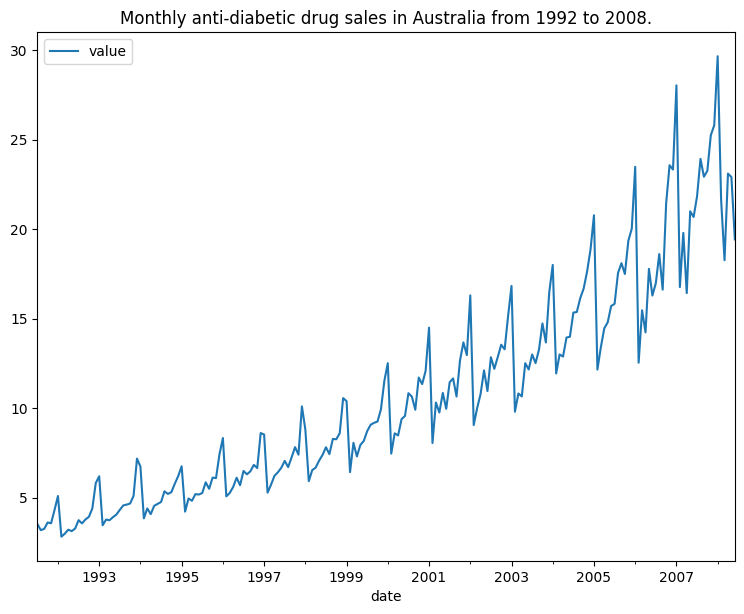

In [ ]:
df.plot(title='Monthly anti-diabetic drug sales in Australia from 1992 to 2008.')
plt.show()


DECOMPOSITION

<Figure size 1000x500 with 0 Axes>

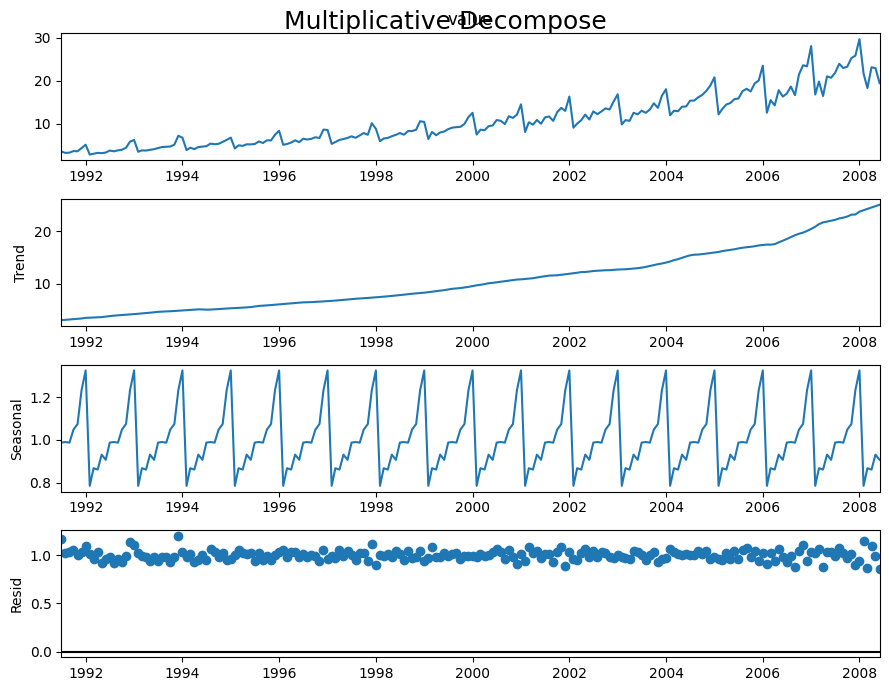

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Multiplicative Decomposition 
result_mul = seasonal_decompose(df['value'], model='multiplicative',extrapolate_trend='freq')

# Additive Decomposition
result_add = seasonal_decompose(df['value'], model='additive',extrapolate_trend='freq')

plt.figure(figsize=(10,5))

# Plot
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=18)
plt.show()

Text(0.5, 0.98, 'Additive Decompose')

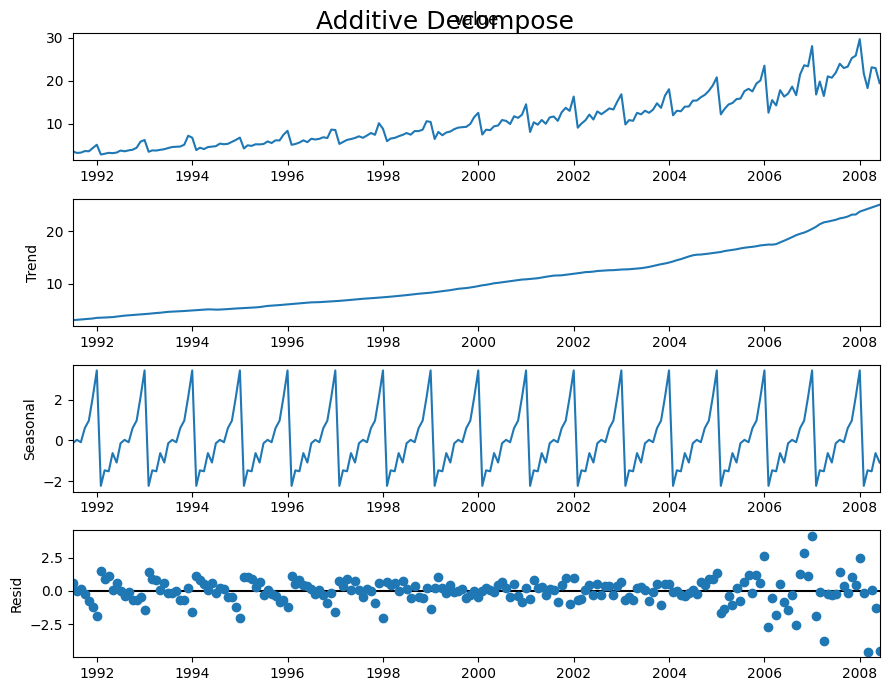

In [ ]:
result_add.plot().suptitle('Additive Decompose', fontsize=18)

when we look at the residuals of the additive decomposition closely, it has some pattern left over. The multiplicative decomposition, however, looks quite random which is good. So ideally, multiplicative decomposition should be preferred for this particular series.

In [ ]:
df_reconstructed = pd.concat([result_mul.seasonal, result_mul.trend, result_mul.resid, result_mul.observed], axis=1)
df_reconstructed.columns = ['seas', 'trend', 'resid', 'actual_values']
df_reconstructed.head()

,seas,trend,resid,actual_values
date,,,,
1991-07-01,0.987845,3.060085,1.166629,3.526591
1991-08-01,0.990481,3.124765,1.027745,3.180891
1991-09-01,0.987476,3.189445,1.032615,3.252221
1991-10-01,1.048329,3.254125,1.058513,3.611003
1991-11-01,1.074527,3.318805,0.999923,3.565869


STATIONARITY CHECK

In [ ]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df.value.values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: 3.1451856893067287
p-value: 1.0
Critial Values:
   1%, -3.465620397124192
Critial Values:
   5%, -2.8770397560752436
Critial Values:
   10%, -2.5750324547306476


Null hypothesis is the time series is non-stationary.

The p-value obtained is greater than significance level of 0.05 and the ADF statistic is higher than any of the critical values. There is no reason to reject the null hypothesis. So, the time series is non-stationary.

AUTO ARIMA MODEL

In [ ]:
#!pip install pmdarima

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm


model = pm.auto_arima(df.value, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=874.416, Time=0.43 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1602.665, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=913.571, Time=0.11 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1392.713, Time=0.18 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=865.809, Time=0.76 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.19 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=867.147, Time=0.59 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=871.437, Time=0.76 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=868.483, Time=0.40 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=858.292, Time=0.91 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=inf, Time=1.02 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=859.374, Time=1.01 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=860.834, Time=1.35 sec

Best model:  ARIMA(3,0,2)(0,0,0)[0]          
Total fit 

RESIDUAL PLOTS

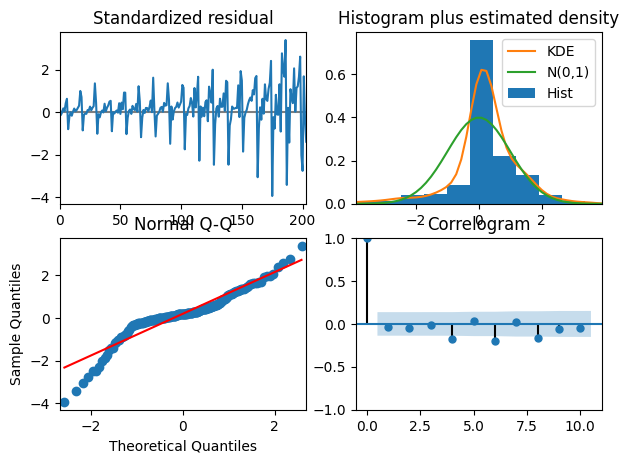

In [ ]:
model.plot_diagnostics(figsize=(7,5))
plt.show()

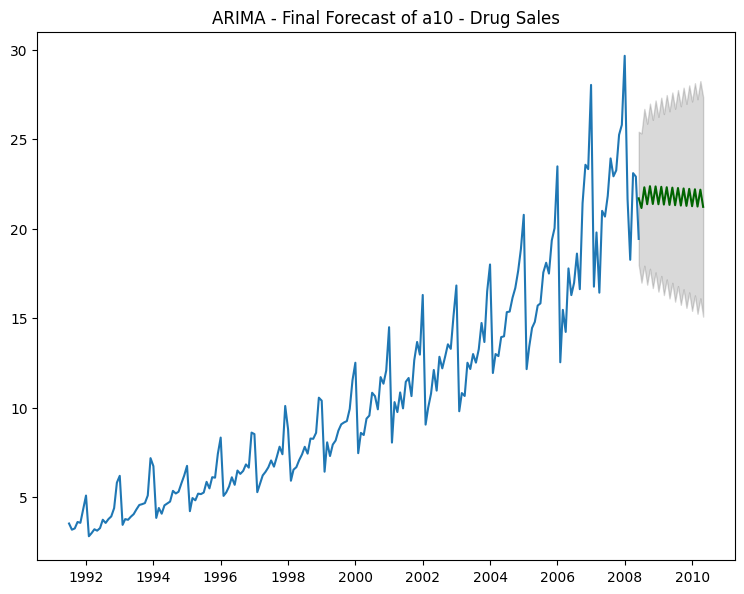

In [ ]:
n_periods = 24
fitted, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(df.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(df)
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("ARIMA - Final Forecast of a10 - Drug Sales")
plt.show()

The problem with plain ARIMA model is it does not support seasonality.

If your time series has defined seasonality, then, go for SARIMA which uses seasonal differencing.

Seasonal differencing is similar to regular differencing, but, instead of subtracting consecutive terms, you subtract the value from previous season.

SARIMA MODEL

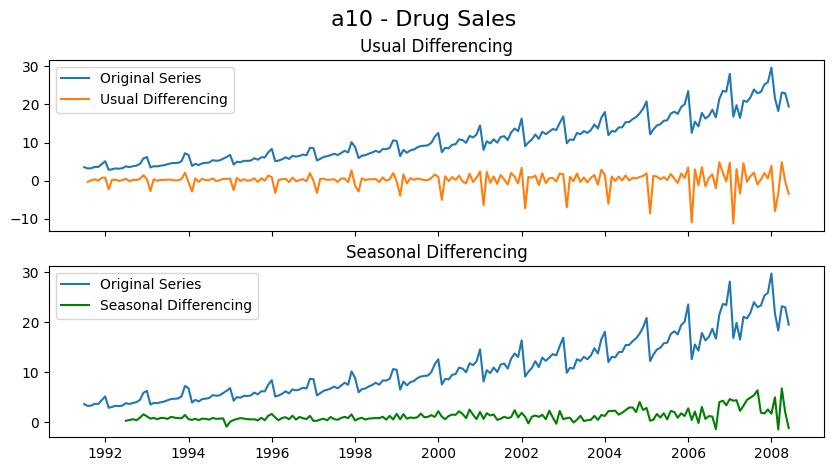

In [ ]:
# Plot
fig, axes = plt.subplots(2, 1, figsize=(10,5), dpi=100, sharex=True)

# Usual Differencing
axes[0].plot(df[:], label='Original Series')
axes[0].plot(df[:].diff(1), label='Usual Differencing')
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='upper left', fontsize=10)


# Seasinal Dei
axes[1].plot(df[:], label='Original Series')
axes[1].plot(df[:].diff(12), label='Seasonal Differencing', color='green')
axes[1].set_title('Seasonal Differencing')
plt.legend(loc='upper left', fontsize=10)
plt.suptitle('a10 - Drug Sales', fontsize=16)
plt.show()

In [ ]:
import pmdarima as pm

# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(df, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=534.818, Time=1.78 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=624.061, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=596.068, Time=0.41 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=611.475, Time=0.30 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=757.274, Time=0.03 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=559.407, Time=0.27 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=1.85 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=536.817, Time=3.43 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=543.106, Time=1.09 sec
 ARIMA(1,0,1)(1,1,2)[12] intercept   : AIC=537.874, Time=4.40 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=594.467, Time=0.28 sec
 ARIMA(2,0,1)(0,1,1)[12] intercept   : AIC=529.829, Time=1.50 sec
 ARIMA(2,0,1)(0,1,0)[12] intercept   : AIC=555.198, Time=0.32 sec
 ARIMA(2,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=2.17 sec
 ARIMA(2,0,1)(0,1,2)[12] intercept   : AI

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  204
Model:             SARIMAX(1, 0, 2)x(1, 1, 2, 12)   Log Likelihood                -254.032
Date:                            Thu, 19 May 2022   AIC                            524.065
Time:                                    04:07:01   BIC                            550.125
Sample:                                         0   HQIC                           534.619
                                            - 204                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0050      0.009      0.551      0.582      -0.013       0.023
ar.L1          0.9763      0.018     52.918      0.000       0.940       1.012
ma.L1         -0.8964      0.056    -15.894      0.000      -1.007      -0.786
ma.L2          0.2027      0.058      3.500      0.000       0.089       0.316
ar.S.L12       0.8479      0.175      4.851      0.000       0.505       1.191
ma.S.L12      -1.5592      0.194     -8.043      0.000      -1.939      -1.179
ma.S.L24       0.7299      0.114      6.384      0.000       0.506       0.954
sigma2         0.7603      0.063     12.003      0.000       0.636       0.884
===================================================================================
Ljung-Box (L1) (Q):                   0.41   Jarque-Bera (JB):               142.10
Prob(Q):                              0.52   Prob(JB):                         0.00
Heteroskedasticity (H):              14.53   Skew:                             0.28
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

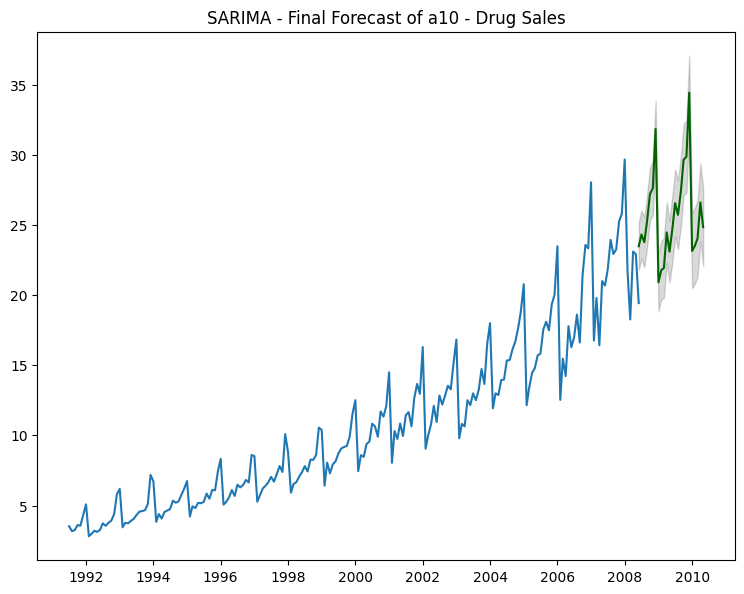

In [ ]:
# Forecast
n_periods = 24
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(df.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(df)
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMA - Final Forecast of a10 - Drug Sales")
plt.show()